## Data Loading

The data from tfrecords will be loaded onto tf.data.dataset (which will prefetch data batches for training).

In [13]:
import tensorflow as tf
import numpy as np
import os
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tfrecord_io import dataset_from_batch

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
files = os.listdir('dataset/')
train_files = []
val_files = []

for idx,file in enumerate(files):
  name = 'dataset/'+file
  if(file[:5] == 'val_0'):
    val_files.append(name)
  elif(file[:7] == 'train_0'):
    train_files.append(name)

train_set = dataset_from_batch(train_files, n_readers = 8, batch_size = 64)
val_set = dataset_from_batch(val_files, n_readers = 1, batch_size = 35)

## Training a Keras Model

In [7]:
with open('Tokenizer/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
total_words = len(tokenizer.word_index)+1
word_index = tokenizer.word_index
embeddings_index = {}
embedding_dim=100

with open('./Embeddings/glove.6B.100d.txt', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((total_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [8]:
mc = ModelCheckpoint('models/LSTM_emb-v1.0_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=15)
#embedding_dim = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dim, input_length = 34, weights = [embeddings_matrix], trainable= False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 20
history = model.fit(train_set, batch_size = 64, steps_per_epoch=429, epochs=num_epochs, 
                    validation_data=val_set, validation_batch_size = 35,
                    validation_steps = 100, verbose=1, callbacks = [mc, es])

Epoch 1/20
429/429 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.5542
Epoch 00001: val_accuracy improved from -inf to 0.65143, saving model to models\LSTM_emb-v1.0_model.h5
429/429 [==============================] - 69s 161ms/step - loss: 0.9366 - accuracy: 0.5542 - val_loss: 0.7766 - val_accuracy: 0.6514
Epoch 2/20
429/429 [==============================] - ETA: 0s - loss: 0.8072 - accuracy: 0.6462
Epoch 00002: val_accuracy improved from 0.65143 to 0.69971, saving model to models\LSTM_emb-v1.0_model.h5
429/429 [==============================] - 74s 173ms/step - loss: 0.8072 - accuracy: 0.6462 - val_loss: 0.7153 - val_accuracy: 0.6997
Epoch 3/20
429/429 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.6717 ETA: 0s - loss: 0.7648 - accuracy
Epoch 00003: val_accuracy improved from 0.69971 to 0.70457, saving model to models\LSTM_emb-v1.0_model.h5
429/429 [==============================] - 77s 180ms/step - loss: 0.7652 - accuracy: 0.6717 - v

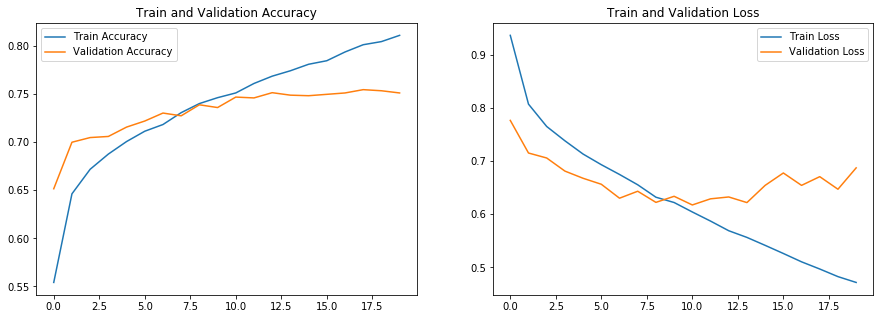

In [15]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))

plt.figure(figsize = (15, 5))

ax = plt.subplot(1,2,1)
plt.title('Train and Validation Accuracy')
sns.lineplot(epochs, train_acc)
sns.lineplot(epochs, val_acc)
plt.legend(["Train Accuracy", "Validation Accuracy"])


ax = plt.subplot(1,2,2)
plt.title('Train and Validation Loss')
sns.lineplot(epochs, train_loss)
sns.lineplot(epochs, val_loss)
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

## Model Analysis

In [16]:
from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model('models/LSTM-v1.0_model.h5')

def enc_to_label(enc):
    for key,val in enc_to_label.items():
        if enc == val:
            return key
    return 'Error'

with open('Tokenizer/label_tokenizer.pickle', 'rb') as handle:
    label_tok = pickle.load(handle)
test_data = np.load('dataset/test_data.npy', allow_pickle = True)
test_labels = np.load('dataset/test_labels.npy')

test_data = test_data[-250:]
test_labels = test_labels[-250:]


y_pred = np.argmax(model.predict(test_data), axis = 1).reshape(250,1)
label_dict = {1:'neutral', 2:'positive', 3: 'negative'}
y_pred = np.vectorize(label_dict.get)(y_pred)
y_true = np.vectorize(label_dict.get)(test_labels)

#### Confusion Matrix

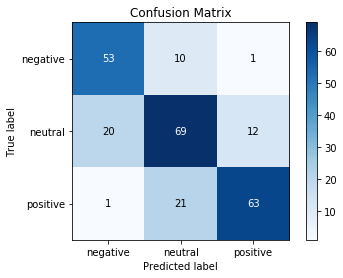

In [18]:
plot_confusion_matrix(y_true, y_pred)

num_classes = 3
plt.ylim(num_classes-0.5, -0.5)
plt.xlim(-0.5, num_classes-0.5)
plt.show()

In [19]:
from sklearn.metrics import precision_recall_fscore_support

precision,recall, f1score, support = precision_recall_fscore_support(y_true, y_pred)
for i in range(num_classes):
    print('Precision for {}: {} '.format(label_dict[i+1], precision[i]))
    print('Recall for {}: {} '.format(label_dict[i+1], recall[i]))
    print('F1 Score for {}: {} '.format(label_dict[i+1], f1score[i]))
    print('\n')

Precision for neutral: 0.7162162162162162 
Recall for neutral: 0.828125 
F1 Score for neutral: 0.7681159420289855 


Precision for positive: 0.69 
Recall for positive: 0.6831683168316832 
F1 Score for positive: 0.6865671641791044 


Precision for negative: 0.8289473684210527 
Recall for negative: 0.7411764705882353 
F1 Score for negative: 0.782608695652174 




## Model Inference

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
with open('Tokenizer/tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)
query = ['Travel only when its necessary']
seq = tok.texts_to_sequences(query)
pad_seq = np.array(pad_sequences(seq,maxlen=34,padding='post'))

with open('Tokenizer/label_tokenizer.pickle', 'rb') as handle:
    label_tok = pickle.load(handle)

p=np.argmax(model.predict(pad_seq))

for key, val in label_tok.word_index.items():
    if p == val:
        print(key)

neutral
